# Word2Vec with TensorFlow

Let's make some embeddings!

# Dependencies and utils

In [1]:
import tensorflow as tf
import math
import numpy as np
import collections
import codecs
import nltk
import re
import numpy as np

def read_data(filename):
    corpus_raw = u""
    with codecs.open(filename,'r','utf-8') as file:
        corpus_raw += file.read()
    return corpus_raw

def extract_words(corpus):
    clean = re.sub("[^a-zA-z]"," ",corpus)
    words = clean.split()
    return words

def extract_corpus_as_integers(corpus,vocab_to_id):
    words_as_int = []
    clean = re.sub("[^a-zA-z]"," ",corpus)
    words = clean.split()
    
    for word in words:
        words_as_int.append(vocab_to_id[word])
    
    return words_as_int

def create_dictionaries(unique_vocab):
    '''
    return: id_to_vocab,vocab_to_id
    '''
    id_to_vocab = {i:ch for i,ch in enumerate(unique_vocab)}
    vocab_to_id = {ch:i for i,ch in enumerate(unique_vocab)}
    return id_to_vocab,vocab_to_id

#TODO
def build_dataset(words, vocabulary_size):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary

def generate_batch(data,batch_size=16,num_skips=1,skip_window=2):
    """Return batch and label from data
    args:
    data: A list of 'int' representing each word of the corpus (use extract_corpus_as_integers function)
    batch_size: The size of the batch (default 16)
    num_skips: How many times to reuse an input to generate a label (default 2)
    skip_window: How many words to consider left and right (default 1)
     
    """ 
    global data_index
    data_index = 0
    assert batch_size % num_skips == 0 
    assert num_skips < 2*skip_window 
    
    batch = np.ndarray(shape=(batch_size),dtype=np.int32)
    labels = np.ndarray(shape=(batch_size,1),dtype=np.int32)
    
    span = 2 * skip_window + 1 # Total length, target + context => [skip_window target skip_window]
    buffer = collections.deque(maxlen=span) #A list-like sequence with maxlen, if more appended, the first dissappears
    
    #Add the the words to buffer [skip_window target skip_window]
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    #A más skips menos vueltas
    for i in range(batch_size // num_skips): 
        target = skip_window #Target at the center
        targets_to_avoid = [skip_window]
        
        for j in range(num_skips):#For each skip
            while target in targets_to_avoid:
                target = np.random.randint(0,span-1)
            targets_to_avoid.append(target)
            
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j,0] = buffer[target]
        
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    #Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch,labels

## Read and prepare data

Alber mode

In [2]:
raw_corpus = read_data('got1.txt')
vocab = extract_words(corpus=raw_corpus)
unique_vocab = set(vocab)
vocabulary_size = len(unique_vocab)

id_to_vocab,vocab_to_id = create_dictionaries(unique_vocab=unique_vocab)

corpus = extract_corpus_as_integers(raw_corpus,vocab_to_id)

print('All words: %d' % len(corpus))
print('All unique words: %d' % len(id_to_vocab))



All words: 331572
All unique words: 15178


Official

In [3]:
'''
raw_corpus = read_data('got1.txt')

vocab = extract_words(corpus=raw_corpus)
unique_vocab = set(vocab)

vocabulary_size = len(unique_vocab)

corpus, count, vocab_to_id, id_to_vocab = build_dataset(words=vocab,vocabulary_size=vocabulary_size)

print('All words: %d' % len(corpus))
print('All unique words: %d' % len(id_to_vocab))
'''

"\nraw_corpus = read_data('got1.txt')\n\nvocab = extract_words(corpus=raw_corpus)\nunique_vocab = set(vocab)\n\nvocabulary_size = len(unique_vocab)\n\ncorpus, count, vocab_to_id, id_to_vocab = build_dataset(words=vocab,vocabulary_size=vocabulary_size)\n\nprint('All words: %d' % len(corpus))\nprint('All unique words: %d' % len(id_to_vocab))\n"

## Build the model

### Embeddings matrix

The embedding matrix is the matrix that will represent the vector representation of each word, so it has to be:

[vocabulary size x number features]

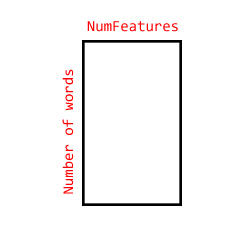

In [4]:
embedding_size = 300

embeddings = tf.Variable(tf.random_uniform(shape=[vocabulary_size,embedding_size],minval=-1.0,maxval=1.0))

### Out weights and biases

The NCE loss is defined in terms of a **logistic regression** model.

For this, we need to define the **weights** and **biases** for each **word**

In [5]:
nce_weights = tf.Variable(tf.truncated_normal(shape=[vocabulary_size,embedding_size],stddev=1.0/math.sqrt(embedding_size)))

nce_biases = tf.Variable(tf.zeros(shape=[vocabulary_size]))

## Skip-Gram model

### Placeholders

Note: Each word is represented as an integer (dict...)

The Skip-Gram model takes **two inputs:**

 - Batch full of integers representing the **source** context **words**
 - Batch full of integers representing the **target words**

In [6]:
batch_size = 16

train_inputs = tf.placeholder(dtype=tf.int32,shape=[batch_size])
train_labels = tf.placeholder(dtype=tf.int32,shape=[batch_size,1])

Now he have to look up the vector for each of the source words, TF helps!

*tf.nn.embedding_lookup():* Looks up `ids` in a list of embedding tensors.

In [7]:
embed = tf.nn.embedding_lookup(embeddings,train_inputs)

### Loss

Let's try to **predict** the **target word** using the **NCE** objective

In [8]:
num_samples = 64 #The number of classes to randomly sample per batch

nce = tf.nn.nce_loss(weights=nce_weights,
                    biases=nce_biases,
                    labels=train_labels,
                    inputs=embed,
                    num_sampled=num_samples,
                    num_classes=vocabulary_size)


loss = tf.reduce_mean(nce)

And, of course, the **optimizer**

In [9]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(loss)

### Similarities

Have fun with some similarities

In [10]:
#Valid set
valid_size = 4     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

valid_dataset = tf.constant(valid_examples,dtype=tf.int32)

In [11]:
#Cosine similarity

norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings),1,keep_dims=True))
normalized_embeddings = embeddings/norm

valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,valid_dataset)

similarity = tf.matmul(valid_embeddings,normalized_embeddings,transpose_b=True)

## Train the model

Feed data and run!

In [12]:
epochs = 100

with tf.Session() as sess:
    average_loss = 0
    tf.global_variables_initializer().run()
    
    for step in range(epochs):
        #Create batch
        inputs,labels = generate_batch(data=corpus,batch_size=batch_size)
        
        #Create feed dict from the returnnn of the generate_batch function
        feed = {train_inputs : inputs, train_labels : labels}
        
        #Perform update every step by evaluating optimizer op
        _,curr_loss = sess.run(fetches=[optimizer,loss],feed_dict=feed)
        
        average_loss += curr_loss
        
        #Show Average Loss info
        if(step % 2000 == 0 and step > 0):
            average_loss /= 2000 #AvLoss of last 2000 batches
            print('Average loss at step %d : %.2f' %(step,average_loss))
            average_loss = 0
            
        #Show similarities
        if (step % 10000 == 0):
            print('Similarities at step %d :' %(step))     
            sim = similarity.eval()
            for i in range(valid_size):#The number of words to valid
                valid_word = id_to_vocab[valid_examples[i]]
                top_k = 8 #Number of nearest neighbours
                nearest = sim[i,:].argsort()[1:top_k + 1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = id_to_vocab[nearest[k]]
                    log_str = "%s %s," % (log_str,close_word)
                print(log_str)
                
        #Final embeddings
        final_embeddings = normalized_embeddings.eval()
        

Similarities at step 0 :
Nearest to starfire: ranger, Bad, executed, better, raper, Great, lurk, Hostage,
Nearest to pains: sagging, James, bountiful, Something, brightest, squash, teetering, jewel,
Nearest to others: Freak, chased, ramp, footing, luxury, brushed, cries, supporting,
Nearest to hoods: fathers, prying, visits, wouldn, Vaes, bushy, surround, strategies,


# Explore some results

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [14]:
print('There are %d words embeded in vector of %d dimensions' %(final_embeddings.shape[0],final_embeddings.shape[1]))

There are 15178 words embeded in vector of 300 dimensions


**Plot**

In [15]:
labels = unique_vocab

if(final_embeddings.shape[1] > 2):
    tsne = TSNE(perplexity=30,n_components=2,init='pca',n_iter=5000)
    low_dim_embs = tsne.fit_transform(final_embeddings)
else:
    low_dim_embs = final_embeddings

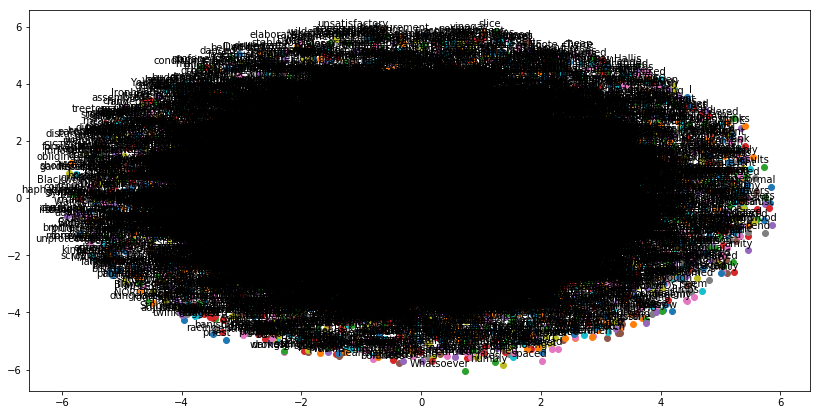

In [16]:
%matplotlib inline

plt.figure(figsize=(14,7))
for i,label in enumerate(labels):
    x,y = low_dim_embs[i,:]
    plt.scatter(x,y)
    plt.annotate(label,xy=(x,y),xytext=(5,2),textcoords='offset points',ha='right',va='bottom')
    
plt.show()